In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing

## 1-1. hyper-parameter 정의

In [2]:
path="./(록스)mitbih_database/"
window_size=160
maximum_counting=10000

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [3]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+f)
    else:
        records.append(path+f)

## 1-2. beat 정의 및 X, Y 초기화

In [4]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]

    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for line in lines[1:]: #lines의 0은 Header
        tmp=line.split(' ')
        tmp=filter(None, tmp)
        next(tmp)
        pos=int(next(tmp))
        arrhythmia_type=next(tmp)
        if(arrhythmia_type in classes):
            arrhythmia_index=classes.index(arrhythmia_type)
            if count_classes[arrhythmia_index]> maximum_counting:
                continue
            else:
                count_classes[arrhythmia_index]+=1
                if(window_size<pos and pos<(len(signals)-window_size)): 
                    beat=signals[pos-window_size+1:pos+window_size] #beat size
                    X.append(beat)
                    Y.append(arrhythmia_index)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'


## 1-3. Data shape

(38611, 319) (38611,)
N
A
V
/
L
R


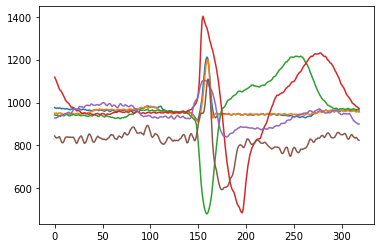

In [5]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])

In [6]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [7]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    9997
1    8071
2    7255
4    7123
5    3619
3    2546
Name: 319, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [8]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
2569,986,987,987,988,987,985,988,988,988,988,...,975,976,978,975,977,977,978,976,976,0
4864,988,988,985,983,984,988,988,987,987,986,...,973,975,977,977,977,975,974,977,978,0
1240,949,949,950,952,954,953,951,951,953,954,...,939,937,934,934,937,939,941,940,938,0
8354,993,998,1004,1005,1003,1000,998,999,999,1000,...,978,978,976,980,981,979,977,973,973,0
3435,952,949,951,948,951,952,954,950,950,949,...,957,960,960,958,957,957,956,958,959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31730,990,995,999,998,999,1000,1000,1003,1005,1005,...,1083,1075,1070,1071,1071,1063,1056,1052,1053,5
32866,1081,1073,1064,1057,1051,1045,1035,1026,1019,1011,...,979,980,976,977,976,977,979,981,979,5
11997,1106,1093,1081,1071,1056,1044,1033,1026,1014,1003,...,1057,1048,1041,1033,1025,1016,1002,999,994,5
11861,1023,1018,1010,1004,993,976,963,954,955,953,...,936,927,923,926,924,919,913,911,907,5


# 2. Modeling

## 2-1. Set 분할

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [10]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [11]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 319, 1) (9000, 319, 1)


## 2-2. modeling 첫 시도

In [179]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [174]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model.h5')
    return (model, history)

In [175]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 310s 471ms/step - loss: 0.3591 - accuracy: 0.9498 - val_loss: 6.9218 - val_accuracy: 0.3862
Epoch 2/2
657/657 [==============================] - 339s 517ms/step - loss: 0.0886 - accuracy: 0.9813 - val_loss: 2.3902 - val_accuracy: 0.6667


In [176]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Accuracy: 66.66666865348816


###  Confusion Matrix

In [192]:
y_pred=model.predict(x_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cnf_matrix)

[[ 422    0    1 1112    6    0]
 [   5  161    0  323  998    2]
 [   8    0 1091  137  270    0]
 [   1    0    5 1359  100    0]
 [  11    1    2   15 1443    0]
 [   3    0    0    0    0 1524]]


In [190]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

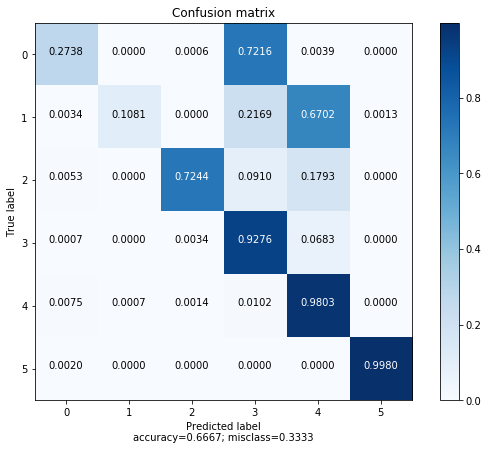

In [191]:
plot_confusion_matrix(cnf_matrix, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix')

# 3. Modeling 두번째 시도

In [165]:
path="./(록스)mitbih_database/"
window_size=160
maximum_counting=10000

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [166]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+f)
    else:
        records.append(path+f)

## 3-1. beat 정의 및 X, Y 초기화

#### set(사람)별로 편차가 큼
200번대 환자들은 유독 차이 큼

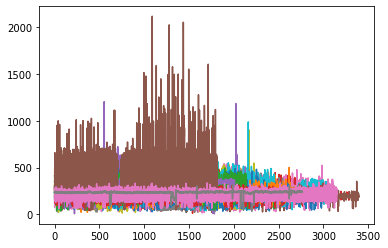

In [167]:
import matplotlib.pyplot as plt

filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+f)
    else:
        records.append(path+f)

avg_list=[]
for i in range(len(annotations)):
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    a_list=[]
    for i in range(3,len(lines)):
        now=list(filter(None,lines[i].split(" ")))[1]
        before=list(filter(None,lines[i-1].split(" ")))[1]
        a_list.append(int(now)-int(before))

    plt.plot(range(0,len(a_list)),a_list)

    a_array=np.array(a_list)
    avg=np.mean(a_array)
    avg_list.append(avg)

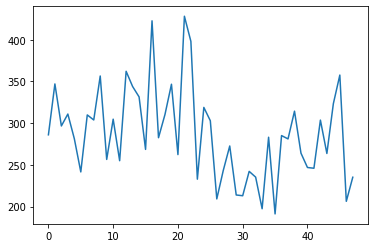

In [168]:
plt.plot(range(0,len(avg_list)),avg_list)

In [169]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            if count_classes[beat_idx] > maximum_counting: #################확인 필요#####################
                continue
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                X.append(beat)
                if len(signals[before_num_sample:now_num_sample])>1000:
                    print("심박 1000 이상 찍힘 : ",annotations[i])
                Y.append(beat_idx)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_database/232annotations.txt
심박 1000 이상 찍힘 :  ./(록스)mitbih_

In [170]:
print(len(X))
print(len(Y))

38612
38612


#### 각각의 비트마다 포함된 포인트 수가 차이 남

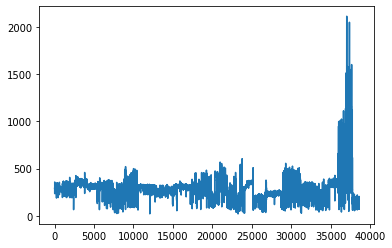

In [171]:
X_len=[len(x) for x in X]
plt.plot(range(0,len(X_len)),X_len)

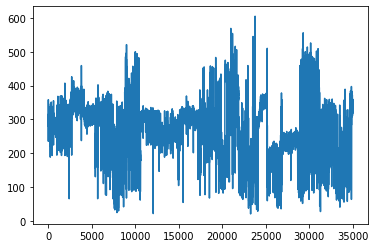

In [172]:
plt.plot(range(0,len(X_len[:35000])),X_len[:35000])

## 3-2. Data shape

#### 한 비트당 포인트 수를 같게 만들어 줌

In [173]:
maximum=max([len(x) for x in X])
for x in X:
    if len(x) < maximum:
        x.extend([0]*(maximum-len(x)))

(38612, 2114) (38612,)
N
A
V
/
L
R
(38612, 2114)


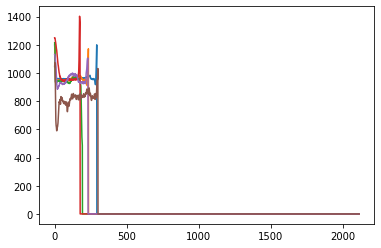

In [174]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])
print(np.shape(X))

In [175]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [176]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    10001
1     8072
2     7253
4     7122
5     3618
3     2546
Name: 2114, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [177]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,...,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114
4659,1388,1393,1362,1281,1158,1035,948,914,918,926,...,0,0,0,0,0,0,0,0,0,0
8413,1275,1259,1222,1184,1155,1135,1104,1066,1026,1001,...,0,0,0,0,0,0,0,0,0,0
5283,1362,1380,1365,1306,1204,1088,993,934,907,900,...,0,0,0,0,0,0,0,0,0,0
5284,1424,1415,1364,1262,1136,1022,950,917,909,909,...,0,0,0,0,0,0,0,0,0,0
4386,1401,1401,1363,1280,1174,1062,979,935,921,921,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31733,1119,1098,1072,1050,1030,1009,981,955,927,898,...,0,0,0,0,0,0,0,0,0,5
32869,1070,1048,1025,996,968,940,913,889,864,834,...,0,0,0,0,0,0,0,0,0,5
12001,1294,1280,1270,1251,1231,1214,1198,1181,1163,1146,...,0,0,0,0,0,0,0,0,0,5
11865,1437,1432,1423,1412,1396,1385,1371,1362,1351,1332,...,0,0,0,0,0,0,0,0,0,5


# 2. Modeling

## 2-1. Set 분할

In [178]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [179]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [180]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 2114, 1) (9000, 2114, 1)


## 2-2. modeling 첫 시도

In [181]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [182]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model2.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model2.h5')
    return (model, history)

In [183]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 2082s 3s/step - loss: 1.1907 - accuracy: 0.8042 - val_loss: 1076.0602 - val_accuracy: 0.1643
Epoch 2/2
 99/657 [===>..........................] - ETA: 28:31 - loss: 0.2079 - accuracy: 0.9432

KeyboardInterrupt: 

In [ ]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)